<a href="https://colab.research.google.com/github/tuntunutycc/HF/blob/main/voice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install gradio
!pip install timm
!pip install inflect
!pip install phonemizer
!apt-get install espeak

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.9/315.9 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 2.9 MB/s eta

In [9]:
import io
import matplotlib.pyplot as plt
import requests
import inflect
from PIL import Image

def load_image_from_url(url):
    return Image.open(requests.get(url, stream=True).raw)

def render_results_in_image(in_pil_img, in_results):
    plt.figure(figsize=(16, 10))
    plt.imshow(in_pil_img)

    ax = plt.gca()

    for prediction in in_results:

        x, y = prediction['box']['xmin'], prediction['box']['ymin']
        w = prediction['box']['xmax'] - prediction['box']['xmin']
        h = prediction['box']['ymax'] - prediction['box']['ymin']

        ax.add_patch(plt.Rectangle((x, y),
                                   w,
                                   h,
                                   fill=False,
                                   color="green",
                                   linewidth=2))
        ax.text(
           x,
           y,
           f"{prediction['label']}: {round(prediction['score']*100, 1)}%",
           color='red'
        )

    plt.axis("off")

    # Save the modified image to a BytesIO object
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png',
                bbox_inches='tight',
                pad_inches=0)
    img_buf.seek(0)
    modified_image = Image.open(img_buf)

    # Close the plot to prevent it from being displayed
    plt.close()

    return modified_image

def summarize_predictions_natural_language(predictions):
    summary = {}
    p = inflect.engine()

    for prediction in predictions:
        label = prediction['label']
        if label in summary:
            summary[label] += 1
        else:
            summary[label] = 1

    result_string = "In this image, there are "
    for i, (label, count) in enumerate(summary.items()):
        count_string = p.number_to_words(count)
        result_string += f"{count_string} {label}"
        if count > 1:
          result_string += "s"

        result_string += " "

        if i == len(summary) - 2:
          result_string += "and "

    # Remove the trailing comma and space
    result_string = result_string.rstrip(', ') + "."

    return result_string


##### To ignore warnings #####
import warnings
import logging
from transformers import logging as hf_logging

def ignore_warnings():
    # Ignore specific Python warnings
    warnings.filterwarnings("ignore", message="Some weights of the model checkpoint")
    warnings.filterwarnings("ignore", message="Could not find image processor class")
    warnings.filterwarnings("ignore", message="The `max_size` parameter is deprecated")

    # Adjust logging for libraries using the logging module
    logging.basicConfig(level=logging.ERROR)
    hf_logging.set_verbosity_error()

########

In [2]:
from transformers import pipeline

In [3]:
od_pipe = pipeline("object-detection", model="facebook/detr-resnet-50")

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

In [4]:
from PIL import Image

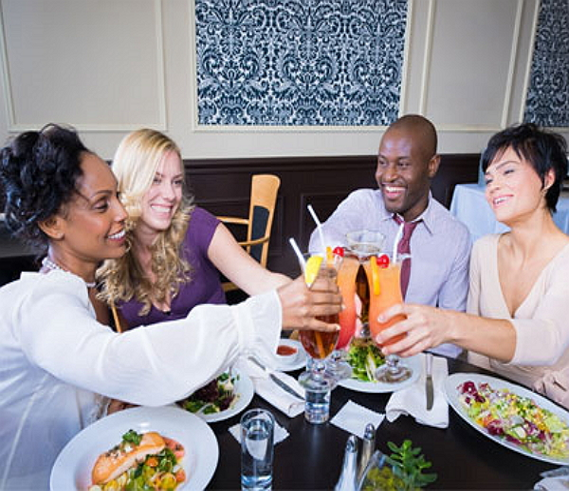

In [5]:
raw_image = Image.open('/content/test.jpeg')
raw_image.resize((569,491))

In [6]:
pl_out=od_pipe(raw_image)

In [7]:
pl_out

[{'score': 0.9411450028419495,
  'label': 'chair',
  'box': {'xmin': 225, 'ymin': 169, 'xmax': 295, 'ymax': 260}},
 {'score': 0.9846691489219666,
  'label': 'person',
  'box': {'xmin': 395, 'ymin': 119, 'xmax': 599, 'ymax': 411}},
 {'score': 0.9978960752487183,
  'label': 'cup',
  'box': {'xmin': 249, 'ymin': 396, 'xmax': 290, 'ymax': 474}},
 {'score': 0.995816171169281,
  'label': 'person',
  'box': {'xmin': 104, 'ymin': 124, 'xmax': 357, 'ymax': 322}},
 {'score': 0.9591200947761536,
  'label': 'wine glass',
  'box': {'xmin': 311, 'ymin': 298, 'xmax': 361, 'ymax': 365}},
 {'score': 0.9732338190078735,
  'label': 'chair',
  'box': {'xmin': 224, 'ymin': 169, 'xmax': 295, 'ymax': 288}},
 {'score': 0.9988069534301758,
  'label': 'person',
  'box': {'xmin': 0, 'ymin': 118, 'xmax': 361, 'ymax': 474}},
 {'score': 0.9527637958526611,
  'label': 'wine glass',
  'box': {'xmin': 374, 'ymin': 244, 'xmax': 430, 'ymax': 369}},
 {'score': 0.9822177290916443,
  'label': 'person',
  'box': {'xmin': 32

In [10]:
processed_image = render_results_in_image(raw_image, pl_out)

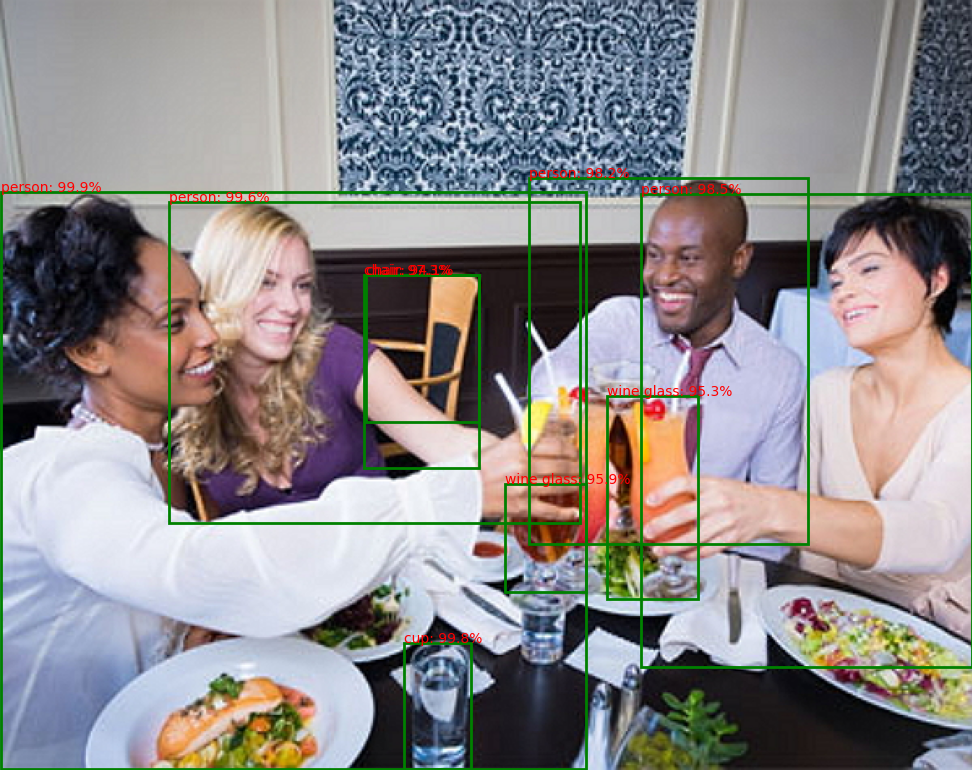

In [11]:
processed_image

In [12]:
text = summarize_predictions_natural_language(pl_out)

In [13]:
text

'In this image, there are two chairs four persons one cup and two wine glasss.'

In [14]:
tts_pipe =pipeline("text-to-speech", model="kakao-enterprise/vits-vctk")

config.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/159M [00:00<?, ?B/s]

Some weights of the model checkpoint at kakao-enterprise/vits-vctk were not used when initializing VitsModel: ['flow.flows.0.wavenet.cond_layer.weight_g', 'flow.flows.0.wavenet.cond_layer.weight_v', 'flow.flows.0.wavenet.in_layers.0.weight_g', 'flow.flows.0.wavenet.in_layers.0.weight_v', 'flow.flows.0.wavenet.in_layers.1.weight_g', 'flow.flows.0.wavenet.in_layers.1.weight_v', 'flow.flows.0.wavenet.in_layers.2.weight_g', 'flow.flows.0.wavenet.in_layers.2.weight_v', 'flow.flows.0.wavenet.in_layers.3.weight_g', 'flow.flows.0.wavenet.in_layers.3.weight_v', 'flow.flows.0.wavenet.res_skip_layers.0.weight_g', 'flow.flows.0.wavenet.res_skip_layers.0.weight_v', 'flow.flows.0.wavenet.res_skip_layers.1.weight_g', 'flow.flows.0.wavenet.res_skip_layers.1.weight_v', 'flow.flows.0.wavenet.res_skip_layers.2.weight_g', 'flow.flows.0.wavenet.res_skip_layers.2.weight_v', 'flow.flows.0.wavenet.res_skip_layers.3.weight_g', 'flow.flows.0.wavenet.res_skip_layers.3.weight_v', 'flow.flows.1.wavenet.cond_layer.

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.14k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/47.0 [00:00<?, ?B/s]

In [15]:
narrated_text = tts_pipe(text)

In [16]:
from IPython.display import Audio as IPythonAudio

In [17]:
IPythonAudio(narrated_text["audio"][0],
             rate = narrated_text["sampling_rate"])